### Get data

In [1]:
# download dataset and labels
! pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded2 = drive.CreateFile({'id': '1HvZH9ys_ufTF-wcRMNFSKS7lT3pJu6YY'}) 
downloaded2.GetContentFile('labels.pkl')

downloaded = drive.CreateFile({'id': '1BqSv5mgxsyP5rhMoAAKFyvPtAH8XLcO6'}) 
downloaded.GetContentFile('embeddings.zip')

! unzip embeddings.zip

Streaming output truncated to the last 5000 lines.
  inflating: user_subset/Azira-Arias.pkl  
  inflating: user_subset/aznology.pkl  
  inflating: user_subset/Aztecprincess94.pkl  
  inflating: user_subset/azulmonk23.pkl  
  inflating: user_subset/azuretres.pkl  
  inflating: user_subset/A_Bored_Canadian.pkl  
  inflating: user_subset/A_Corrupted_Angel.pkl  
  inflating: user_subset/a_nu_start101.pkl  
  inflating: user_subset/b-tchlasagna.pkl  
  inflating: user_subset/B-Town-xx.pkl  
  inflating: user_subset/B0BA_F33TT.pkl  
  inflating: user_subset/b1g_disappointment.pkl  
  inflating: user_subset/b1polarone.pkl  
  inflating: user_subset/b378n.pkl   
  inflating: user_subset/b3cc4j3nn.pkl  
  inflating: user_subset/b4xt3r.pkl  
  inflating: user_subset/Baacipitus.pkl  
  inflating: user_subset/BabushkasReddit.pkl  
  inflating: user_subset/Babydoll9713.pkl  
  inflating: user_subset/babydollies.pkl  
  inflating: user_subset/BabyDubs69.pkl  
  inflating: user_subset/BabyPacoPequeno

In [0]:
# !unzip embeddings.zip

In [3]:
# load labels and user embeddings and create Users data obj
import torch
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from csv import reader
import pickle
from os import listdir
import random

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Users(Dataset):
    def __init__(self, embedPath, labelPath): 
        self.users, self.labels = [], []
        users = {}
        labels = pickle.load(open(labelPath, 'rb')) # { username: [ depressionPercent, vaderScore ] }
        fileList = listdir(embedPath)

        for user in fileList: # must download and unzip embeddings.zip first
            users[user[:-4]] = pickle.load(open('%s/%s' % (embedPath, user), 'rb'))

        intersection = list(set(users.keys()).intersection(set(labels.keys())))
        
        # largest_tensor_size = 0
        for i in intersection:
            userTensor = torch.tensor([users[i]])
            # if userTensor.shape > largest_tensor_size:
            #   largest_tensor_size = userTensor.shape
            if list(userTensor.shape)[1] != 1: # exclude single comment users
                self.users.append(userTensor)
                self.labels.append(torch.tensor([labels[i][0]]))
        
        # if batched:
        #   # padding for minibatching
        #   for user in users:
            

        print(len(self), self[0])

    def __getitem__(self, i):
        return self.users[i], self.labels[i] # change to include others
    
    def __len__(self):
        assert len(self.users) == len(self.labels)
        return len(self.users)

# def my_collate(batch):
#     data = [item[0] for item in batch]
#     target = [item[1] for item in batch]
#     target = torch.Tensor(target)
#     return [data, target]

train, valid, test = random_split(Users('user_subset', 'labels.pkl'), [4280, 538, 538])

# dataloader_params = {'batch_size': 4, 'shuffle': True, 'collate_fn': my_collate}
# train, test = DataLoader(train, **dataloader_params), DataLoader(test, **dataloader_params)


5356 (tensor([[[ 0.0075,  0.0897,  0.0457,  ...,  0.0105,  0.0291, -0.0197],
         [ 0.0075, -0.1444, -0.0628,  ..., -0.1045, -0.0613, -0.0468],
         [ 0.0075,  0.1475,  0.0763,  ...,  0.0218,  0.0476,  0.0686],
         ...,
         [ 0.0075,  0.0218,  0.1011,  ...,  0.0758, -0.0186, -0.0315],
         [ 0.0075, -0.0267,  0.0232,  ...,  0.0137,  0.0075, -0.0234],
         [ 0.0075, -0.0328,  0.0246,  ...,  0.0403,  0.0795, -0.0104]]]), tensor([0.1053]))


In [0]:
batch_size = 20

def my_collate(batch):
  # pad and get the original lengths
  # print(len(batch))
  idx = 0
  max_len = 100
  X_lens = torch.zeros((len(batch)))
  b = []
  for x, y in batch:
    X_lens[idx] = x.shape[1]
    padded = torch.zeros((1, max_len, x.shape[2]))
    padded[:, 0:x.shape[1], :] = x 
    # print(list(batch[idx])[0])
    p = [padded, y]
    b.append(p)
    # print(padded)
    idx += 1
  # print(b)
  return [b, X_lens]

In [2]:
# def batch_size():

train_dataloader_params = {'batch_size': batch_size, 'shuffle': True, 'collate_fn': my_collate}
# val_dataloader_params = {'batch_size': 500, 'shuffle': True}#, 'collate_fn': my_collate}

train_loader = DataLoader(train)#, **train_dataloader_params)

# train, valid, test = DataLoader(train, **dataloader_params), DataLoader(valid, **dataloader_params), DataLoader(test, **dataloader_params)

NameError: ignored

In [0]:
import numpy as np
# batch, X_lens, _ = train_loader
i = 0
print(len(train_loader))
for batch, X_lens in train_loader:
  X, Y = list(zip(*batch))
  if i == 0:
    # print(X)
    print(type(Y))
  i+=1

214
<class 'tuple'>


In [0]:
import torch

t = torch.arange(8).reshape(1,4,2).float()
x = torch.zeros((1, t.shape[1]+2, t.shape[2]+2))
x[:, 1:-1, 1:-1] = t

print(t.shape)
print(x.shape)

# kinda wasteful memory wise, can revise later if it works
idx = 0
max_len = 100
for x, y in train:
  # if i == 0:
  # t = torch.arange(8).reshape(1, 4, 2).float()
  # x = torch.nn.functional.pad(t, (1, 1, 1, 1))
  # print(torch.nn.functional.pad(x, (1, 1, 1, 1)).shape)
  # print(x.shape)
  padded = torch.zeros((1, max_len, x.shape[2]))
  padded[:, 0:x.shape[1], :] = x 
  list(train[idx])[0] = padded
  idx += 1
for x, y in train:
  print(x.shape)

torch.Size([1, 4, 2])
torch.Size([1, 6, 4])
torch.Size([1, 4, 4096])
torch.Size([1, 83, 4096])
torch.Size([1, 34, 4096])
torch.Size([1, 100, 4096])
torch.Size([1, 10, 4096])
torch.Size([1, 100, 4096])
torch.Size([1, 52, 4096])
torch.Size([1, 25, 4096])
torch.Size([1, 100, 4096])
torch.Size([1, 80, 4096])
torch.Size([1, 19, 4096])
torch.Size([1, 11, 4096])
torch.Size([1, 100, 4096])
torch.Size([1, 100, 4096])
torch.Size([1, 42, 4096])
torch.Size([1, 2, 4096])
torch.Size([1, 3, 4096])
torch.Size([1, 91, 4096])
torch.Size([1, 24, 4096])
torch.Size([1, 6, 4096])
torch.Size([1, 2, 4096])
torch.Size([1, 79, 4096])
torch.Size([1, 50, 4096])
torch.Size([1, 13, 4096])
torch.Size([1, 4, 4096])
torch.Size([1, 9, 4096])
torch.Size([1, 19, 4096])
torch.Size([1, 15, 4096])
torch.Size([1, 69, 4096])
torch.Size([1, 53, 4096])
torch.Size([1, 7, 4096])
torch.Size([1, 5, 4096])
torch.Size([1, 16, 4096])
torch.Size([1, 34, 4096])
torch.Size([1, 33, 4096])
torch.Size([1, 35, 4096])
torch.Size([1, 33, 4096]

In [0]:
t = (1, 2)
t[0] = 3

TypeError: ignored

In [0]:
# in Users:
# find the tensor with the maximum shape DONE
# pad using the [2] embedding dimension DONE

# in forward:
# pack_padded_sequence? something so that padded items wont be shown
# run through lstm
# undo packing with (pad_packed_sequence or something else)
# might need to do something more for linear find out later!

# in loss:
# 

In [0]:
# valid = DataLoader(valid, **dataloader_params)

### Classifier Training

In [0]:
class LSTM_Classifier(nn.Module):
    def __init__(
        self,
        batch_size=4,
        embedding_dimension=4096, # from glove to infersent?
        hidden_size=300, 
        n_layers=1, # multiple?
    ):
        super(LSTM_Classifier, self).__init__()
        
        # hyperparams
        self.n_layers = n_layers
        self.embedding_dimension = embedding_dimension
        self.hidden_size = hidden_size
        self.batch_size = batch_size

        # model layers
        self.lstm = nn.LSTM(self.embedding_dimension, self.hidden_size)
        self.fc = nn.Linear(hidden_size, 1) 

    def forward(self, user):
        f_output, h_output = self.lstm(user)
        output = self.fc(f_output[0][-1])
        
        # get classification
        output = torch.sigmoid(output)
        return output #, h_output

NameError: ignored

In [0]:
# train with 0s and 1s on the classifier, use binary crossentropy
# train with only non-zeros on the regressor, use mse

True


TypeError: ignored

In [0]:
model = LSTM_Classifier().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.BCELoss()
epochs = 7
model.train()

train_losses = []
for epoch in range(epochs):
  # if epoch != 0:
  #   break
  total = 0
  losses = []
  predictions = []
  real = []
  for X, Y in train:
      # if total > 0:
      #   break
      X, Y = X.to(device), Y.to(device) # torch.FloatTensor(([0.0] if Y.item() < 0.41 else [1.0])).to(device)
      
      # get binary label
      y = Y.clone()
      y[y>0]=1
      
      # print(Y.shape)
      pred = model(X)
      # print(pred.shape)
      loss = criterion(pred, y)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # accuracy stuff
      p = 0.0
      if pred.item() >= .50:
        p = 1.0
      predictions.append(p)
      real.append(y.item())

      losses.append(loss.item())
      total += 1

      # if total % 200 == 0:
      #     print(y.item(), loss.item())
      
      # reset memory
      del y; torch.cuda.empty_cache()
  
  # do validation loss/accuracy crap
  val_predictions = []
  val_real = []
  val_losses = []
  val_total = 0

  # maybe convert this into its own method since it's the same shit for test
  for X, Y in valid:

      X, Y = X.to(device), Y.to(device)
      
      # get binary label
      y = Y.clone()
      y[y>0]=1

      # get loss
      pred = model(X)
      val_loss = criterion(pred, y)

      # accuracy stuff
      p = 0.0
      if pred.item() >= .50:
        p = 1.0
      val_predictions.append(p)
      val_real.append(y.item())

      # append loss and increment total
      val_losses.append(loss.item() if val_loss.item() < 1 else 0)
      val_total += 1
      
      # if total % 20 == 0:
      # if val_loss.item() > 0.1:
      #     print(pred.item(), y.item(), val_loss.item())

      del y; torch.cuda.empty_cache()

  epoch_loss = sum(losses) / total
  epoch_train_acc = np.sum(np.equal(predictions,real)) / total

  epoch_val_loss = sum(val_losses) / val_total
  epoch_val_acc = np.sum(np.equal(val_predictions,val_real)) / val_total

  print(epoch, epoch_loss, epoch_train_acc, epoch_val_loss, epoch_val_acc)
  train_losses.append(epoch_loss)

  # use the printing method that they have cuz that was p beast

print(train_losses)

0 0.6527346230138128 0.6240654205607477 0.47432015708831166 0.6468401486988847
1 0.6045232791993245 0.6733644859813084 0.39443040071366886 0.654275092936803
2 0.5821493773864773 0.6866822429906542 0.3454521935446998 0.6505576208178439
3 0.5613911274758551 0.702803738317757 0.317794840076599 0.654275092936803
4 0.5385960625993631 0.722196261682243 0.3029334623795903 0.6524163568773235
5 0.5130107936758135 0.7404205607476636 0.307017488772098 0.6598513011152416
6 0.4854395371370629 0.7577102803738318 0.3157257147438021 0.6617100371747212
[0.6527346230138128, 0.6045232791993245, 0.5821493773864773, 0.5613911274758551, 0.5385960625993631, 0.5130107936758135, 0.4854395371370629]


In [0]:
import numpy as np
torch.no_grad()
total = 0
losses = []

predictions = []
real = []

for X, Y in test:

    X, Y = X.to(device), Y.to(device)
    
    # get binary label
    y = Y.clone()
    y[y>0]=1

    # get loss
    pred = model(X)
    loss = criterion(pred, y)

    # accuracy stuff
    p = 0.0
    if pred.item() >= .50:
      p = 1.0
    predictions.append(p)
    real.append(y.item())

    # append loss and increment total
    losses.append(loss.item() if loss.item() < 1 else 0)
    total += 1
    
    # if total % 20 == 0:
    if loss.item() > 0.1:
        print(pred.item(), y.item(), loss.item())

    del y; torch.cuda.empty_cache()

test_loss = sum(losses) / total
acc = np.sum(np.equal(predictions,real)) / total
print(test_loss)
print("Accuracy: " + str(acc))

0.41248619556427 1.0 0.8855525255203247
0.20492535829544067 0.0 0.2293192744255066
0.281804621219635 0.0 0.33101361989974976
0.5155934691429138 0.0 0.7248308062553406
0.4906652867794037 0.0 0.6746499538421631
0.38872087001800537 0.0 0.492201566696167
0.8631354570388794 0.0 1.9887635707855225
0.27657753229141235 1.0 1.2852641344070435
0.39827626943588257 0.0 0.507956862449646
0.3442208170890808 1.0 1.0664719343185425
0.540579080581665 0.0 0.7777884602546692
0.15247312188148499 0.0 0.16543269157409668
0.4161005914211273 1.0 0.8768282532691956
0.4035077393054962 0.0 0.5166889429092407
0.5390779376029968 0.0 0.7745262980461121
0.6099228262901306 1.0 0.4944228529930115
0.8587657809257507 0.0 1.9573355913162231
0.5663243532180786 0.0 0.8354583978652954
0.41248619556427 0.0 0.5318555235862732
0.5374871492385864 0.0 0.7710809707641602
0.4642030596733093 1.0 0.7674331665039062
0.42686110734939575 0.0 0.5566272139549255
0.1337672621011734 0.0 0.14360164105892181
0.41248619556427 0.0 0.5318555235

In [0]:
print(predictions)
print(real)

[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,

### LSTM Regressor Training

In [0]:
class LSTM_Regressor(nn.Module):
    def __init__(
        self,
        batch_size=4,
        embedding_dimension=4096, # from glove to infersent?
        hidden_size=300, 
        n_layers=1, # multiple?
    ):
        super(LSTM_Regressor, self).__init__()
        self.n_layers = n_layers
        self.embedding_dimension = embedding_dimension
        self.hidden_size = hidden_size
        self.batch_size = batch_size

        self.lstm = nn.LSTM(self.embedding_dimension, self.hidden_size)
        self.fc = nn.Linear(hidden_size, 1) 

    def forward(self, user):
        f_output, h_output = self.lstm(user)
        output = self.fc(f_output[0][-1])
        output = torch.sigmoid(output)
        return output #, h_output

In [0]:
model = LSTM_Regressor().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss() # nn.BCELoss()
epochs = 10
model.train()

train_losses = []
for epoch in range(epochs):
    total = 0
    losses = []
    for X, Y in train:

        X, Y = X.to(device), Y.to(device) # torch.FloatTensor(([0.0] if Y.item() < 0.41 else [1.0])).to(device)
        
        if Y.item() <= 0:
          continue
        
        # print(Y.shape)
        pred = model(X)
        # print(pred.shape)
        loss = criterion(pred, Y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        total += 1

        # if total % 200 == 0:
        #     print(Y.item(), loss.item())
  
  # maybe convert this into its own method since it's the same shit for test
  for X, Y in valid:

      X, Y = X.to(device), Y.to(device)
      
      # get binary label
      y = Y.clone()
      y[y>0]=1

      # get loss
      pred = model(X)
      val_loss = criterion(pred, y)

      # accuracy stuff
      p = 0.0
      if pred.item() >= .50:
        p = 1.0
      val_predictions.append(p)
      val_real.append(y.item())

      # append loss and increment total
      val_losses.append(loss.item() if val_loss.item() < 1 else 0)
      val_total += 1

      del y; torch.cuda.empty_cache()
    
    epoch_loss = sum(losses) / total
    print(epoch, epoch_loss)
    train_losses.append(epoch_loss)

print(train_losses)

0 0.08360166435862557
1 0.07508735085506947
2 0.070493222504412
3 0.066605457106366
4 0.06274115584591418
5 0.058591545576498406
6 0.05407103726332958
7 0.04930244106239146
8 0.04454813974848006
9 0.040064947055160414
[0.08360166435862557, 0.07508735085506947, 0.070493222504412, 0.066605457106366, 0.06274115584591418, 0.058591545576498406, 0.05407103726332958, 0.04930244106239146, 0.04454813974848006, 0.040064947055160414]


In [0]:
import numpy as np
torch.no_grad()
total = 0
losses = []
preds = []

for X, Y in test:

    X, Y = X.to(device), Y.to(device)

    # only check labels > 0
    if Y.item() <= 0:
          continue

    # get loss
    pred = model(X)
    loss = criterion(pred, Y)

    # append loss and increment total
    preds.append(pred.item())
    losses.append(loss.item() if loss.item() < 1 else 0)
    total += 1
    
    # if total % 20 == 0:
    # if loss.item() > 0.1:
    #     print(pred.item(), Y.item(), loss.item())

test_loss = sum(losses) / total
print(test_loss)

0.10135695548567458


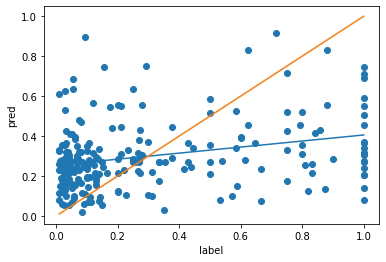

In [0]:
import numpy as np
import matplotlib.pyplot as plt

labels = [data[1].item() for data in test if data[1].item() > 0]
uni_labels = np.unique(labels)

plt.xlabel('label')
plt.ylabel('pred')
plt.scatter(labels, preds)
plt.plot(np.unique(labels), np.poly1d(np.polyfit(labels, preds, 1))(np.unique(labels)))
plt.plot(np.unique(labels), np.unique(labels))

In [0]:
print(sorted(labels))

[0.009999999776482582, 0.009999999776482582, 0.009999999776482582, 0.009999999776482582, 0.009999999776482582, 0.009999999776482582, 0.010638297535479069, 0.011363636702299118, 0.013888888992369175, 0.015384615398943424, 0.01785714365541935, 0.018518518656492233, 0.019999999552965164, 0.019999999552965164, 0.019999999552965164, 0.020408162847161293, 0.020408162847161293, 0.022727273404598236, 0.024390242993831635, 0.024390242993831635, 0.02500000037252903, 0.02631578966975212, 0.02666666731238365, 0.027027027681469917, 0.027027027681469917, 0.027027027681469917, 0.02857142873108387, 0.029411764815449715, 0.029999999329447746, 0.029999999329447746, 0.029999999329447746, 0.029999999329447746, 0.029999999329447746, 0.029999999329447746, 0.029999999329447746, 0.029999999329447746, 0.029999999329447746, 0.029999999329447746, 0.03030303120613098, 0.03030303120613098, 0.03076923079788685, 0.03125, 0.03703703731298447, 0.03703703731298447, 0.03703703731298447, 0.03750000149011612, 0.0392156876

In [0]:
print(max(preds))

1.2940363883972168


### GRU + Attention Regressor

In [0]:
def matrix_mul(input, weight, bias=False):
    feature_list = []
    for feature in input.squeeze(0):
        feature = torch.mm(feature.unsqueeze(0), weight)
        if isinstance(bias, torch.nn.parameter.Parameter):
            feature = feature + bias.expand(feature.size()[0], bias.size()[1])
        feature = torch.tanh(feature)#.unsqueeze(0) ?
        feature_list.append(feature)

    return torch.cat(feature_list, 0)#.squeeze(1) ?

def element_wise_mul(input1, input2):
    feature_list = []
    for feature_1, feature_2 in zip(input1.squeeze(0), input2):
        feature = feature_1 * feature_2
        feature_list.append(feature.unsqueeze(0))

    output = torch.cat(feature_list, 0)
    return torch.sum(output, 0).unsqueeze(0)

class AN(nn.Module):
    def __init__(
        self,
        # batch_size=4,
        embedding_dimension=4096, 
        hidden_size=128, 
        # n_layers=1, # multiple?
    ):
        super(AN, self).__init__()
        # self.n_layers = n_layers
        self.hidden_size = hidden_size
        # self.batch_size = batch_size

        self.sent_weight = nn.Parameter(torch.randn(2 * hidden_size, 2 * hidden_size))
        self.sent_bias = nn.Parameter(torch.randn(1, 2 * hidden_size))
        self.context_weight = nn.Parameter(torch.randn(2 * hidden_size, 1))

        self.gru = nn.GRU(embedding_dimension, hidden_size, bidirectional=True)
        self.fc = nn.Linear(2 * hidden_size, 1) 
        self._create_weights(mean=0.005)

    def _create_weights(self, mean=0.0, std=0.01):
        self.sent_weight.data.normal_(mean, std)
        self.sent_bias.data.normal_(mean, std)
        self.context_weight.data.normal_(mean, std)

    def forward(self, user):
        f_output, h_output = self.gru(user)
        output = matrix_mul(f_output, self.sent_weight, self.sent_bias)
        output = F.dropout(output)
        output = matrix_mul(output, self.context_weight)#.permute(1, 0) ?
        output = F.softmax(output)
        output = element_wise_mul(f_output, output).squeeze(0) # '''output.permute(1, 0) ?'''
        output = self.fc(output)
        output = F.sigmoid(output)

        return output #, h_output

In [0]:
model = AN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss() # nn.BCELoss()
epochs = 10
model.train()

train_losses = []
for epoch in range(epochs):
    total = 0
    losses = []
    for X, Y in train:

        X, Y = X.to(device), Y.to(device) # torch.FloatTensor(([0.0] if Y.item() < 0.41 else [1.0])).to(device)
        
        if Y.item() <= 0:
          continue
        
        # print(Y.shape)
        pred = model(X)
        # print(pred.shape)
        loss = criterion(pred, Y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        total += 1

        # if total % 200 == 0:
        #     print(Y.item(), loss.item())
  
    val_losses = []
    val_total = 0
    # maybe convert this into its own method since it's the same shit for test
    for X, Y in valid:

        X, Y = X.to(device), Y.to(device)

        if Y.item() <= 0:
            continue

        # get loss
        pred = model(X)
        val_loss = criterion(pred, Y)

        # append loss and increment total
        val_losses.append(loss.item() if val_loss.item() < 1 else 0)
        val_total += 1
    
    epoch_loss = sum(losses) / total
    val_epoch_loss = sum(val_losses) / val_total
    print(epoch, epoch_loss, val_epoch_loss)
    train_losses.append(epoch_loss)

print(train_losses)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0 0.05977688073626029 0.11718512326478958
1 0.0475363999419221 0.11413600295782089
2 0.04623566311216129 0.10780781507492065
3 0.04013338745630492 0.105560801923275
4 0.03878416921288798 0.1059015691280365
5 0.037508113277758395 0.1059516966342926
6 0.036708512592184016 0.10515382140874863
7 0.036076046839522036 0.10389305651187897
8 0.03542312508858319 0.10292599350214005
9 0.034720580146863855 0.10162980854511261
[0.05977688073626029, 0.0475363999419221, 0.04623566311216129, 0.04013338745630492, 0.03878416921288798, 0.037508113277758395, 0.036708512592184016, 0.036076046839522036, 0.03542312508858319, 0.034720580146863855]


In [0]:
import numpy as np
torch.no_grad()
total = 0
losses = []
preds = []

for X, Y in test:

    X, Y = X.to(device), Y.to(device)

    # only check labels > 0
    if Y.item() <= 0:
          continue

    # get loss
    pred = model(X)
    loss = criterion(pred, Y)

    # append loss and increment total
    preds.append(pred.item())
    losses.append(loss.item() if loss.item() < 1 else 0)
    total += 1
    
    # if total % 20 == 0:
    # if loss.item() > 0.1:
    #     print(pred.item(), Y.item(), loss.item())

test_loss = sum(losses) / total
print(test_loss)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0.047771766845745425


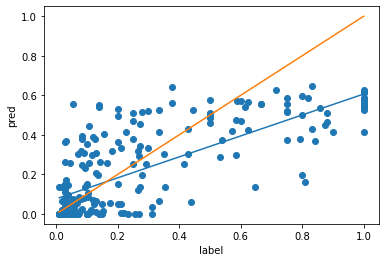

In [0]:
import numpy as np
import matplotlib.pyplot as plt

labels = [data[1].item() for data in test if data[1].item() > 0]
uni_labels = np.unique(labels)

plt.xlabel('label')
plt.ylabel('pred')
plt.scatter(labels, preds)
plt.plot(np.unique(labels), np.poly1d(np.polyfit(labels, preds, 1))(np.unique(labels)))
plt.plot(np.unique(labels), np.unique(labels))

In [0]:
model = AN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.BCELoss()
epochs = 10
model.train()

train_losses = []
for epoch in range(epochs):
  # if epoch != 0:
  #   break
  total = 0
  losses = []
  predictions = []
  real = []
  for X, Y in train:
      # if total > 0:
      #   break
      X, Y = X.to(device), Y.to(device) # torch.FloatTensor(([0.0] if Y.item() < 0.41 else [1.0])).to(device)
      
      # get binary label
      y = Y.clone()
      y[y>0]=1
      
      # print(Y.shape)
      pred = model(X)
      # print(pred.shape)
      loss = criterion(pred, y)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # accuracy stuff
      p = 0.0
      if pred.item() >= .50:
        p = 1.0
      predictions.append(p)
      real.append(y.item())

      losses.append(loss.item())
      total += 1

      # if total % 200 == 0:
      #     print(y.item(), loss.item())
      
      # reset memory
      del y; torch.cuda.empty_cache()
  
  # do validation loss/accuracy crap
  val_predictions = []
  val_real = []
  val_losses = []
  val_total = 0

  # maybe convert this into its own method since it's the same shit for test
  for X, Y in valid:

      X, Y = X.to(device), Y.to(device)
      
      # get binary label
      y = Y.clone()
      y[y>0]=1

      # get loss
      pred = model(X)
      val_loss = criterion(pred, y)

      # accuracy stuff
      p = 0.0
      if pred.item() >= .50:
        p = 1.0
      val_predictions.append(p)
      val_real.append(y.item())

      # append loss and increment total
      val_losses.append(loss.item() if val_loss.item() < 1 else 0)
      val_total += 1
      
      # if total % 20 == 0:
      # if val_loss.item() > 0.1:
      #     print(pred.item(), y.item(), val_loss.item())

      del y; torch.cuda.empty_cache()

  epoch_loss = sum(losses) / total
  epoch_train_acc = np.sum(np.equal(predictions,real)) / total

  epoch_val_loss = sum(val_losses) / val_total
  epoch_val_acc = np.sum(np.equal(val_predictions,val_real)) / val_total

  print(epoch, epoch_loss, epoch_train_acc, epoch_val_loss, epoch_val_acc)
  train_losses.append(epoch_loss)

  # use the printing method that they have cuz that was p beast

print(train_losses)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0 0.6551052712948894 0.7294392523364486 0.4448665750514176 0.8104089219330854
1 0.5469440102241129 0.7754672897196262 0.4496718427948792 0.8141263940520446
2 0.5202579198299392 0.7920560747663551 0.4426900573822645 0.8085501858736059
3 0.5049904368983683 0.8018691588785046 0.43404697136586484 0.8178438661710037
4 0.49305248644360505 0.8074766355140187 0.4261840956361764 0.8141263940520446
5 0.48323728714684255 0.8186915887850468 0.4204409973328885 0.8234200743494424
6 0.47489122388694244 0.8238317757009346 0.41466970614341114 0.8215613382899628
7 0.4675326293630913 0.8266355140186916 0.4084289469461902 0.8234200743494424
8 0.4608398619552209 0.8299065420560747 0.39984472179058317 0.8308550185873605
9 0.4546089760138372 0.830607476635514 0.3944819124214711 0.8271375464684015
[0.6551052712948894, 0.5469440102241129, 0.5202579198299392, 0.5049904368983683, 0.49305248644360505, 0.48323728714684255, 0.47489122388694244, 0.4675326293630913, 0.4608398619552209, 0.4546089760138372]


In [0]:
import numpy as np
torch.no_grad()
total = 0
losses = []

predictions = []
real = []

for X, Y in test:

    X, Y = X.to(device), Y.to(device)
    
    # get binary label
    y = Y.clone()
    y[y>0]=1

    # get loss
    pred = model(X)
    loss = criterion(pred, y)

    # accuracy stuff
    p = 0.0
    if pred.item() >= .50:
      p = 1.0
    predictions.append(p)
    real.append(y.item())

    # append loss and increment total
    losses.append(loss.item() if loss.item() < 1 else 0)
    total += 1
    
    # if total % 20 == 0:
    if loss.item() > 0.1:
        print(pred.item(), y.item(), loss.item())

    del y; torch.cuda.empty_cache()

test_loss = sum(losses) / total
test_acc = np.sum(np.equal(predictions,real)) / total
print(test_loss)
print("Accuracy: " + str(test_acc))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0.14744995534420013 0.0 0.1595233827829361
0.23597538471221924 0.0 0.26915526390075684
0.5717893242835999 1.0 0.558984637260437
0.49098411202430725 1.0 0.71134352684021
0.3717392385005951 0.0 0.46480000019073486
0.3227699100971222 0.0 0.3897441625595093
0.4553884267807007 0.0 0.607682466506958
0.18735143542289734 0.0 0.207456573843956
0.5449361205101013 0.0 0.7873174548149109
0.7210368514060974 0.0 1.2766755819320679
0.35079213976860046 0.0 0.43200239539146423
0.7723330855369568 1.0 0.25833937525749207
0.5127886533737183 0.0 0.7190572619438171
0.49049967527389526 0.0 0.6743248105049133
0.8192137479782104 1.0 0.19941024482250214
0.6891961693763733 1.0 0.37222933769226074
0.6383434534072876 1.0 0.44887882471084595
0.08391549438238144 1.0 2.47794508934021
0.20599234104156494 0.0 0.23066216707229614
0.3379536271095276 0.0 0.4124196767807007
0.00038920907536521554 1.0 7.851393699645996
0.30485761165618896 0.0 0.36363857984542847
0.3481178283691406 0.0 0.42789146304130554
0.6185228824615479 

### Multi-class Experimentation

In [0]:
# Re-label with GRU
def matrix_mul(input, weight, bias=False):
    feature_list = []
    for feature in input.squeeze(0):
        feature = torch.mm(feature.unsqueeze(0), weight)
        if isinstance(bias, torch.nn.parameter.Parameter):
            feature = feature + bias.expand(feature.size()[0], bias.size()[1])
        feature = torch.tanh(feature)#.unsqueeze(0) ?
        feature_list.append(feature)

    return torch.cat(feature_list, 0)#.squeeze(1) ?

def element_wise_mul(input1, input2):
    feature_list = []
    for feature_1, feature_2 in zip(input1.squeeze(0), input2):
        feature = feature_1 * feature_2
        feature_list.append(feature.unsqueeze(0))

    output = torch.cat(feature_list, 0)
    return torch.sum(output, 0).unsqueeze(0)

class AN_MultiClassifier(nn.Module):
    def __init__(
        self,
        batch_size=4,
        embedding_dimension=4096, 
        hidden_size=128, 
        # n_layers=1, # multiple?
        num_labels = 3
    ):
        super(AN_MultiClassifier, self).__init__()
        # self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.batch_size = batch_size

        self.sent_weight = nn.Parameter(torch.randn(2 * hidden_size, 2 * hidden_size))
        self.sent_bias = nn.Parameter(torch.randn(1, 2 * hidden_size))
        self.context_weight = nn.Parameter(torch.randn(2 * hidden_size, 1))

        self.gru = nn.GRU(embedding_dimension, hidden_size, bidirectional=True)
        self.fc = nn.Linear(2 * hidden_size, num_labels) 
        self._create_weights(mean=0.005)

    def _create_weights(self, mean=0.0, std=0.01):
        self.sent_weight.data.normal_(mean, std)
        self.sent_bias.data.normal_(mean, std)
        self.context_weight.data.normal_(mean, std)

    def forward(self, user, X_lengths):

        # print(sum(X_lengths))
        # print((user[2].shape))
        # user = torch.nn.utils.rnn.pack_padded_sequence(user, X_lengths, batch_first=False, enforce_sorted=False)
        # print((user[2].shape))

        f_output, h_output = self.gru(user)
        # print("hi")
        output = matrix_mul(f_output, self.sent_weight, self.sent_bias)
        output = F.dropout(output)
        output = matrix_mul(output, self.context_weight)#.permute(1, 0) ?
        output = F.softmax(output)
        output = element_wise_mul(f_output, output).squeeze(0) # '''output.permute(1, 0) ?'''
        output = self.fc(output)
        # output = F.softmax(output)

        return output #, h_output

class AN_Regressor(nn.Module):
    def __init__(
        self,
        # batch_size=4,
        embedding_dimension=4096, 
        hidden_size=128, 
        # n_layers=1, # multiple?
    ):
        super(AN_Regressor, self).__init__()
        # self.n_layers = n_layers
        self.hidden_size = hidden_size
        # self.batch_size = batch_size

        self.sent_weight = nn.Parameter(torch.randn(2 * hidden_size, 2 * hidden_size))
        self.sent_bias = nn.Parameter(torch.randn(1, 2 * hidden_size))
        self.context_weight = nn.Parameter(torch.randn(2 * hidden_size, 1))

        self.gru = nn.GRU(embedding_dimension, hidden_size, bidirectional=True)
        self.fc = nn.Linear(2 * hidden_size, 1) 
        self._create_weights(mean=0.005)

    def _create_weights(self, mean=0.0, std=0.01):
        self.sent_weight.data.normal_(mean, std)
        self.sent_bias.data.normal_(mean, std)
        self.context_weight.data.normal_(mean, std)

    # need to pass user_lengths
    def forward(self, user):

        # pack_padded_sequence user with enforce_sort false, set back to user
        f_output, h_output = self.gru(user)
        output = matrix_mul(f_output, self.sent_weight, self.sent_bias)
        output = F.dropout(output)
        output = matrix_mul(output, self.context_weight)#.permute(1, 0) ?
        output = F.softmax(output)
        output = element_wise_mul(f_output, output).squeeze(0) # '''output.permute(1, 0) ?'''
        # pad_packed_sequence the output

        # re-shape for linear?
        output = self.fc(output)
        output = torch.sigmoid(output)

        return output #, h_output

In [0]:
import numpy as np

num_labels = 3
learning_rate = .0001#.001 # .0001
model = AN_MultiClassifier(batch_size=batch_size, num_labels=num_labels).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
epochs = 8
model.train()

train_losses = []
val_losses = []

print(len(train))
for epoch in range(epochs):
  # if epoch != 0:
  #   break
  total = 0
  losses = []
  predictions = []
  real = []
  
  # batch, X_lens = train_loader
  for X, Y in train:
  # for batch, X_lens in train_loader:
      
      # if total > 0:
      #   break
      # X, Y = batch[0]
      # print(batch)

      # X, Y = list(zip(*batch))
      # print(list(X))
      # X = torch.stack(list(X))
      # print(len(X))
      # Y = torch.tensor(list(Y))
      X, Y = X.to(device), Y.to(device) # torch.FloatTensor(([0.0] if Y.item() < 0.41 else [1.0])).to(device)
      
      print(type(Y))

      ##### get label
      y = Y.clone()
      y[(y>0.2) & (y<=1)]=2
      y[(y>0) & (y<=0.2)]=1
      
      # print(X.shape)
      # print(y.shape)

      pred = model(X, X_lens)
      loss = criterion(pred.unsqueeze(dim=0), y.long())

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      ##### accuracy stuff
      predictions.append(pred.argmax())
      real.append(y.item())

      losses.append(loss.item())
      total += 1

      if total % 200 == 0:
          print(y.item(), loss.item())
      
      # reset memory
      del y; torch.cuda.empty_cache()
  
  # do validation loss/accuracy crap
  val_predictions = []
  val_real = []
  val_epoch_losses = []
  val_total = 0

  print("ello")

  # maybe convert this into its own method since it's the same shit for test
  for X, Y in valid:

      X, Y = X.to(device), Y.to(device)
      
      ##### get binary label
      y = Y.clone()
      y[y>0.2 and y<=1]=2
      y[y>0 and y<=0.2]=1

      # get loss
      pred = model(X[0])
      # print(pred.unsqueeze())
      val_loss = criterion(pred.unsqueeze(dim=0), y[0].long())

      ##### accuracy stuff
      val_predictions.append(pred.argmax())
      val_real.append(y.item())

      # append loss and increment total
      val_epoch_losses.append(loss.item() if val_loss.item() < 1 else 0)
      val_total += 1
      
      # if total % 20 == 0:
      # if val_loss.item() > 0.1:
      #     print(pred.item(), y.item(), val_loss.item())

      del y; torch.cuda.empty_cache()

  epoch_loss = sum(losses) / total
  epoch_train_acc = np.sum(np.equal(predictions,real)) / total

  epoch_val_loss = sum(val_epoch_losses) / val_total
  epoch_val_acc = np.sum(np.equal(val_predictions,val_real)) / val_total

  print(epoch, epoch_loss, epoch_train_acc, epoch_val_loss, epoch_val_acc)
  train_losses.append(epoch_loss)
  val_losses.append(epoch_val_loss)

  # use the printing method that they have cuz that was p beast

print(train_losses)

RuntimeError: ignored

In [0]:
 import numpy as np
torch.no_grad()
total = 0
losses = []

predictions = []
real = []

for X, Y in test:

    X, Y = X.to(device), Y.to(device)
    
    # get binary label
    y = Y.clone()
    y[y>0.2 and y<=1]=2
    y[y>0 and y<=0.2]=1

    # get loss
    pred = model(X[0])
    loss = criterion(pred.unsqueeze(dim=0), y[0].long())

    # accuracy stuff
    # p = 0.0
    # if pred.item() >= .50:
    #   p = 1.0
    predictions.append(pred.argmax().item())
    real.append(y.item())

    # append loss and increment total
    losses.append(loss.item() if loss.item() < 1 else 0)
    total += 1
    
    # if total % 20 == 0:
    # if loss.item() > 0.1:
    #     print(pred.item(), y.item(), loss.item())

    del y; torch.cuda.empty_cache()

test_loss = sum(losses) / total
test_acc = np.sum(np.equal(predictions,real)) / total
print(test_loss)
print("Accuracy: " + str(test_acc))

[0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 2.0, 0.0, 0.0, 1.0, 1.0, 2.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 2.0, 2.0, 0.0, 0.0, 1.0, 0.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 2.0, 2.0, 1.0, 1.0, 0.0, 2.0, 2.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 2.0, 1.0, 1.0, 0.0, 1.0, 2.0, 2.0, 2.0, 0.0, 1.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 1.0, 2.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 2.0, 0.0, 0.0, 0.0, 1.0, 2.0, 0.0, 1.0, 1.0, 2.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 2.0, 1.0, 1.0, 2.0, 2.0, 0.0, 1.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 2.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 2.0, 0.0, 1.0, 0.0,

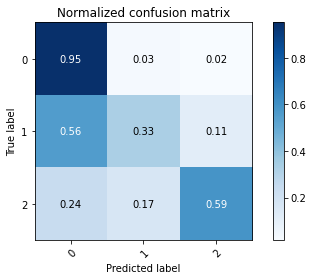

In [0]:
print(real)
print(predictions)
plot_confusion_matrix(real,predictions,classes=[0,1,2],normalize=True)

In [8]:
model = AN_Regressor().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss() # nn.BCELoss()
epochs = 10
model.train()

train_losses = []
val_losses = []
for epoch in range(epochs):
    total = 0
    losses = []
    for X, Y in train:

        X, Y = X.to(device), Y.to(device) # torch.FloatTensor(([0.0] if Y.item() < 0.41 else [1.0])).to(device)
        
        if Y.item() <= 0 or Y.item() > 0.2:
          continue
        
        # print(Y.shape)
        pred = model(X)
        # print(pred.shape)
        loss = criterion(pred, Y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        total += 1

        # if total % 200 == 0:
        #     print(Y.item(), loss.item())
  
    val_epoch_losses = []
    val_total = 0
    # maybe convert this into its own method since it's the same shit for test
    for X, Y in valid:

        X, Y = X.to(device), Y.to(device)

        if Y.item() <= 0 or Y.item() > 0.2: 
            continue

        # get loss
        pred = model(X)
        val_loss = criterion(pred, Y)

        # append loss and increment total
        val_epoch_losses.append(loss.item() if val_loss.item() < 1 else 0)
        val_total += 1
    
    epoch_loss = sum(losses) / total
    val_epoch_loss = sum(val_epoch_losses) / val_total
    print(epoch, epoch_loss, val_epoch_loss)
    train_losses.append(epoch_loss)
    val_losses.append(val_epoch_loss)

print(train_losses)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:102: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


0 0.008422315208258533 0.003897319547832012
1 0.007917964752836038 3.216837649233639e-05
2 0.007706857470110667 0.005823203828185797
3 0.00843095279675884 0.005758326966315508
4 0.008388557546232366 0.005299526732414961
5 0.008227135806472486 0.005593613255769014
6 0.008296200777465174 0.001087473938241601
7 0.007724308119236864 0.0036582699976861477
8 0.007685690994314414 0.0015573835698887706
9 0.006776584995452074 0.0030684408266097307
[0.008422315208258533, 0.007917964752836038, 0.007706857470110667, 0.00843095279675884, 0.008388557546232366, 0.008227135806472486, 0.008296200777465174, 0.007724308119236864, 0.007685690994314414, 0.006776584995452074]


In [11]:
import numpy as np
torch.no_grad()
total = 0
losses = []

predictions = []
real = []

for X, Y in test:

    X, Y = X.to(device), Y.to(device)
    
    # get binary label
    y = Y.clone()
    # y[y>0.2 and y<=1]=2
    # y[y>0 and y<=0.2]=1
    
    if Y.item() <= 0 or Y.item() > 0.2: 
        continue

    # get loss
    pred = model(X)
    loss = criterion(pred, y.long())

    # accuracy stuff
    # p = 0.0
    # if pred.item() >= .50:
    #   p = 1.0
    # predictions.append(pred.argmax().item())
    # real.append(y.item())

    # append loss and increment total
    losses.append(loss.item() if loss.item() < 1 else 0)
    total += 1
    
    # if total % 20 == 0:
    # if loss.item() > 0.1:
    #     print(pred.item(), y.item(), loss.item())

    del y; torch.cuda.empty_cache()

test_loss = sum(losses) / total
# test_acc = np.sum(np.equal(predictions,real)) / total
print(test_loss)
# print("Accuracy: " + str(test_acc))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:102: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


0.0031943072814585548


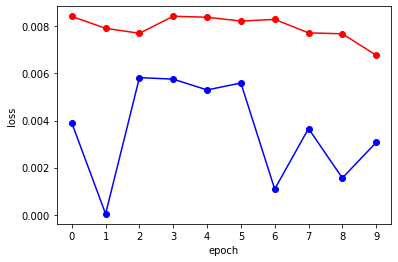

In [13]:
from matplotlib import pyplot as plt

plt.xticks(range(len(train_losses)))
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(train_losses, '-ro')
plt.plot(val_losses, '-bo')

# torch.save(model.state_dict(), 'model_save.pkl')
# upload = drive.CreateFile({'title': 'model_save_5-8-20.pkl'}) # change name
# upload.SetContentFile('model_save.pkl')
# upload.Upload()

In [14]:
model = AN_Regressor().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss() # nn.BCELoss()
epochs = 10
model.train()

train_losses = []
val_losses = []
for epoch in range(epochs):
    total = 0
    losses = []
    for X, Y in train:

        X, Y = X.to(device), Y.to(device) # torch.FloatTensor(([0.0] if Y.item() < 0.41 else [1.0])).to(device)
        
        if Y.item() < 0.2:
          continue
        
        # print(Y.shape)
        pred = model(X)
        # print(pred.shape)
        loss = criterion(pred, Y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        total += 1

        # if total % 200 == 0:
        #     print(Y.item(), loss.item())
  
    val_epoch_losses = []
    val_total = 0
    # maybe convert this into its own method since it's the same shit for test
    for X, Y in valid:

        X, Y = X.to(device), Y.to(device)

        if Y.item() < 0.2: 
            continue

        # get loss
        pred = model(X)
        val_loss = criterion(pred, Y)

        # append loss and increment total
        val_epoch_losses.append(loss.item() if val_loss.item() < 1 else 0)
        val_total += 1
    
    epoch_loss = sum(losses) / total
    val_epoch_loss = sum(val_epoch_losses) / val_total
    print(epoch, epoch_loss, val_epoch_loss)
    train_losses.append(epoch_loss)
    val_losses.append(val_epoch_loss)

print(train_losses)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:102: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


0 0.09220451236264451 0.1369771808385849
1 0.08063194076023719 0.008314395323395729
2 0.06898411985663687 0.008048782125115395
3 0.06512083472524055 0.002669580979272723
4 0.061473309265149996 0.0003609771083574742
5 0.05828539448568103 0.00013548988499678671
6 0.055877871856053855 3.9788850699551404e-05
7 0.054076897928670785 7.957727939356118e-05
8 0.052862139648866845 0.00014870618178974837
9 0.051902400766760136 0.00019540294306352735
[0.09220451236264451, 0.08063194076023719, 0.06898411985663687, 0.06512083472524055, 0.061473309265149996, 0.05828539448568103, 0.055877871856053855, 0.054076897928670785, 0.052862139648866845, 0.051902400766760136]


In [15]:
import numpy as np
torch.no_grad()
total = 0
losses = []

predictions = []
real = []

for X, Y in test:

    X, Y = X.to(device), Y.to(device)
    
    # get binary label
    y = Y.clone()
    # y[y>0.2 and y<=1]=2
    # y[y>0 and y<=0.2]=1
    
    if Y.item() <= 0 or Y.item() > 0.2: 
        continue

    # get loss
    pred = model(X)
    loss = criterion(pred, y.long())

    # accuracy stuff
    # p = 0.0
    # if pred.item() >= .50:
    #   p = 1.0
    # predictions.append(pred.argmax().item())
    # real.append(y.item())

    # append loss and increment total
    losses.append(loss.item() if loss.item() < 1 else 0)
    total += 1
    
    # if total % 20 == 0:
    # if loss.item() > 0.1:
    #     print(pred.item(), y.item(), loss.item())

    del y; torch.cuda.empty_cache()

test_loss = sum(losses) / total
# test_acc = np.sum(np.equal(predictions,real)) / total
print(test_loss)
# print("Accuracy: " + str(test_acc))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:102: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


0.10442978542417992


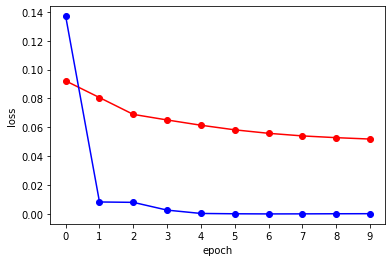

In [16]:
from matplotlib import pyplot as plt

plt.xticks(range(len(train_losses)))
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(train_losses, '-ro')
plt.plot(val_losses, '-bo')

In [0]:
confusion_matrix()

## Confusion Matrix

In [0]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
#     # Only use the labels that appear in the data
#     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax